# Notebook Example to use Shadow Measurement

This example show how to extract the spectrum from a 1D disordered Heisenber chain with the following hamiltonian:

$$
H_S = 3(\epsilon + J - K) + \frac{3J_S}{4} - \frac{J_S}{4}\left(\sigma_1\sigma_2 + \sigma_1\sigma_3 + \sigma_2\sigma_3\right)
$$

### Imports

In [1]:
# hqs open-source libs
from qoqo_quest import Backend
from qoqo.devices import AllToAllDevice
from qoqo import QuantumProgram


# Generic libs.
from numpy.linalg import eigh
from scipy.fft import fft
from collections import defaultdict
import matplotlib.pyplot as plt  
import numpy as np
import json

# local import
from qoqo_shadows import (
    measure_and_process_circuit,
    generate_operators
    )

In [2]:
# Number of qubits
num_qubits = 3 

# Trotter steps
max_trotter_step  = 200
trotter_timestep = 10 # This has to be the same value as in `create_quantum_program.py`


# Max frequency (Nyquist frequency)
print(f"Max frequency measurable: {1/(2*trotter_timestep)}")
# Min frequency
print(f"Min frequency measurable: {1/(max_trotter_step * trotter_timestep)}")


# general device and backend
device = AllToAllDevice(
    num_qubits,
    ["RotateX", "RotateZ", "RotateY"],
    ["CNOT"],
    1.0)
backend = Backend(num_qubits)

Max frequency measurable: 0.05
Min frequency measurable: 0.0005


A pre-initialized quantum program is available locally. Created using the file `create_quantum_program.py`.

### Initialization of the Quantum Program and Hamiltonian

The quantum program is initialized with the following key components:

1. **Device Setup**:
   - An **AllToAllDevice** model is used, with `num_qubits = 3`, which defines interactions between all qubits.
   - The device supports a set of gate operations: `["RotateX", "RotateZ", "RotateY"]` for single-qubit rotations and `["CNOT"]` for two-qubit entangling operations.
   - A decoherence time of `1.0` is applied across qubits for the supported gates.


2. **Hamiltonian Initialization**:
   - The Hamiltonian is built using the `SpinHamiltonianSystem` to represent a **spin-based model** for three spins.
   - A simplified spin Hamiltonian, , is 
   $$
    H_S = 3(\epsilon + J - K) + \frac{3J_S}{4} - \frac{J_S}{4}\left(\sigma_1\sigma_2 + \sigma_1\sigma_3 + \sigma_2\sigma_3\right)
    $$

   
   constructed using parameters:
     - `epsilon`: on-site energy,
     - `J`: Coulomb integral,
     - `K`: exchange integral,
     - `J_S`: effective spin coupling constant.

4. **Noise and Quantum Program**:
   - The **quantum program** is initialized with the Hamiltonian and key parameters like:
     - `trotter_timestep`: dictating the timeframe for time evolution. Default value is 10.
     - `initialisation`: specifying the initial state of the qubits ([0, 0, 1]).

5. **Measurement Circuits**:
   - Measurement circuits are generated using the **XYZ Shadow Circuit**, targeting **state reconstruction** across Pauli-X, Y, and Z bases for the qubits.
   - These measurement circuits are tailored to the hardware using the **single_qubit_gate_decomposition** to break down gates that are not directly supported by the device.
   - The quantum program is subsequently combined with these measurement circuits, and noise (if specified) is inserted by the **NoiseInserter**.

6. **Program Export**:
   - Once the program is fully defined and noise is applied (if needed), it is serialized into JSON format and written to a file (`quantum_program.json`) for subsequent use in simulation or execution on a quantum processor.


In [3]:
## Load the quantum program
with open("quantum_program.json", 'r') as f:
    quantum_program =  QuantumProgram.from_json(json.load(f))
    print("Quantum Program Loaded")

Quantum Program Loaded


# Run the simulation 

Here you can run the simulation for `max_trotter_step` steps

In [4]:
evolution_snapshot = {}
print("Running for trotter steps:")
for trotterstep in range(1, max_trotter_step+1):
    print(trotterstep, end='\n' if trotterstep % 50 == 0 else ', ')
    all_shadows  = measure_and_process_circuit(trotterstep,
                                               quantum_program,
                                               backend,
                                               verbose=False
                                              )
    evolution_snapshot[trotterstep] = all_shadows

Running for trotter steps:
1, 

2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50
51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100
101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150
151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200


# Post-processing

#### `Measurement Operators selection`

Here one can choose the operator to measure on the classical shadows by specifing the locality, i.e. the number of non-identity Paulis for a given Pauli string. 
In general low locality offer higher precision measure for the same shadow snapshot.

In [5]:
# Pick max locality 
locality = 3
assert locality <= num_qubits, "locality should be less than or equal to the number of qubits"

operators_dict = {}
for loc in range(1,locality+1):
    loc_operators = generate_operators(num_qubits,loc)
    operators_dict.update(loc_operators)
    print(f"Generated {len(loc_operators)} operators for {num_qubits} qubits with locality {loc}.")

print("Total number of operators to measure: ", len(operators_dict))
for label, op in operators_dict.items():
    print(f"{label}", end=',')#, Operator:\n{op}\n")

Generated 9 operators for 3 qubits with locality 1.
Generated 27 operators for 3 qubits with locality 2.
Generated 27 operators for 3 qubits with locality 3.
Total number of operators to measure:  63
XII,IXI,IIX,YII,IYI,IIY,ZII,IZI,IIZ,XXI,XIX,IXX,XYI,XIY,IXY,XZI,XIZ,IXZ,YXI,YIX,IYX,YYI,YIY,IYY,YZI,YIZ,IYZ,ZXI,ZIX,IZX,ZYI,ZIY,IZY,ZZI,ZIZ,IZZ,XXX,XXY,XXZ,XYX,XYY,XYZ,XZX,XZY,XZZ,YXX,YXY,YXZ,YYX,YYY,YYZ,YZX,YZY,YZZ,ZXX,ZXY,ZXZ,ZYX,ZYY,ZYZ,ZZX,ZZY,ZZZ,

## `Signal Analysis`


### High-Level Overview of Matrix Operations from Shadow Snapshot Data

This code extracts and visualizes insights from **shadow snapshot data**, a quantum or simulation-based method of estimating operator values over time. It performs two main actions:

1. **Data Organization and Transformation**:
   - The code first **standardizes the measurements** of different operators over time. This data is structured into a matrix \( D \), where each row represents how a particular operator evolves or behaves over a series of time steps (or experimental trials).

2. **Matrix Construction and Analysis**:
   - From this data matrix:
     - **\( D^T \)**, the **transpose** of the data matrix, is computed to reorganize data and is visualized as a heatmap to observe the operator behaviors across different time indices.
     - **\( C = D^T D \)** is a matrix that reveals **similarities or correlations** between time points by examining the shared behavior of observables.


In [6]:
# Initialize dictionaries using defaultdict for simpler list and dictionary management
shadow_measurements = defaultdict(dict)  # Organize by trotterstep and operator
aggregated_measurements = defaultdict(list)  # Organize by operator

# Iterate over each trotterstep in evolution_snapshot
for trotterstep, snapshots in evolution_snapshot.items():
    
    # Compute the average shadow once for the current trotterstep
    average_shadow = np.mean(snapshots, axis=0)
    
    # Measure each operator on the shadow density matrices
    for operator_label, operator in operators_dict.items():
        
        # Compute the trace for the operator on the shadow density matrix
        value = np.trace(np.dot(operator, average_shadow))
        
        # Store the value for the current trotterstep and operator
        shadow_measurements[trotterstep][operator_label] = value
        
        # Append the value to the list of aggregated measurements for this operator
        aggregated_measurements[operator_label].append(value)

In [7]:
# Step 1: Compute Mean and Standard Deviation, then Standardize  
standardized_measurements = {}  
for op, values in aggregated_measurements.items():
    values_array = np.array(values)

    # Compute mean and standard deviation
    mean = np.mean(values_array)
    std = np.std(values_array)
    # Avoid division by zero: if std is zero, keep the values as zeros
    if std == 0:
        standardized_values = np.zeros_like(values_array)
    else:
        standardized_values = (values_array - mean) / std
    
    # Store the standardized measurements
    standardized_measurements[op] = standardized_values

operators = list(standardized_measurements.keys())  # list of operator labels

# Step 2: Construct Data Matrix D where each row is the set of standardized measurements for an operator
D = np.array([standardized_measurements[op] for op in operators])

# Step 3: Construct the covariance Gram matrix C = D.T @ D (D^T * D)
C = np.dot(D.T, D)

### Plot the Data Matrix D and C

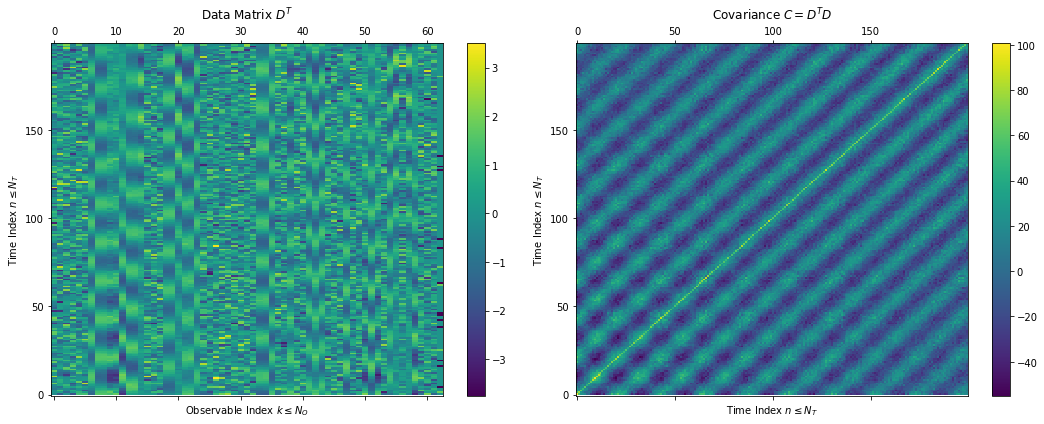

In [8]:
# Set up the matplotlib figure and axes  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Plotting the data matrix D^T  
cax1 = ax1.matshow(np.real(D.T), aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('Data Matrix $D^T$')
ax1.set_ylabel('Time Index $n \leq N_T$')
ax1.set_xlabel('Observable Index $k \leq N_O$')

# Plotting the matrix C  
cax2 = ax2.matshow(np.real(C), aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('Covariance $C = D^T D$')
ax2.set_xlabel('Time Index $n \leq N_T$')
ax2.set_ylabel('Time Index $n \leq N_T$')

# Show the plot  
plt.tight_layout()
plt.show()

In [9]:
# Set the cutoff to retain top n dominant eigenvectors
cutoff_index = 1  # Adjust this value as needed


# Step 4: Perform Eigenvalue Decomposition on C
eigenvalues, eigenvectors = eigh(C)

# Step 5: Sort Eigenvalues and Eigenvectors in Descending Order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


# Check if the cutoff_index is within valid bounds, cap at the max available
cutoff_index = min(cutoff_index, len(sorted_eigenvalues))
if cutoff_index == 0:
    raise ValueError("The cutoff_index must be at least 1.")


# Retain the top dominant eigenvectors
dominant_eigenvectors = sorted_eigenvectors[:, :cutoff_index]
print(f"Retaining {cutoff_index} dominant eigenvectors from {len(sorted_eigenvalues)} total.")


# Step 6: Compute Fourier Transform of the Dominant Eigenvectors
frequency_components = fft(dominant_eigenvectors, axis=0)

# Step 7: Calculate the Shadow Spectrum
# Number of points from the FFT
N = frequency_components.shape[0]
# Identify half of the FFT to focus only on positive frequencies
half_point = N // 2

# Generate positive frequency axis using the FFT frequency function
positive_frequencies = np.fft.fftfreq(N, d=trotter_timestep)[:half_point]

# Compute the spectrum as the absolute value of the Fourier components
spectrum = np.abs(frequency_components[:half_point])

Retaining 1 dominant eigenvectors from 200 total.


## Plot spectrum

The spectrum for the provided Hamiltonian is plotted agains the known peak.

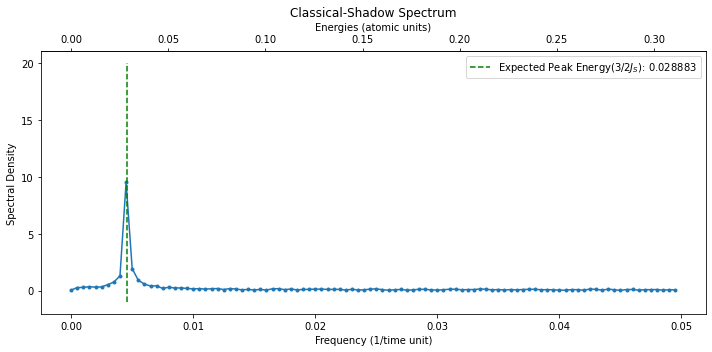

Observed peak energy: 0.028274 atomic units
Expected peak energy: 0.028883 atomic units
Observed peak frequency: 0.004500 1/time unit
Expected peak frequency: 0.004597 1/time unit


In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the spectrum
ax1.plot(positive_frequencies, spectrum, '.-')
ax1.set_xlabel('Frequency (1/time unit)')
ax1.set_ylabel('Spectral Density')

# Add vertical line for expected peak
J_S = 0.019255
expected_peak_energy = J_S * 3/2 
expected_peak_frequency = expected_peak_energy / (2*np.pi)
ax1.vlines(expected_peak_frequency, -1, 20, linestyles="--", colors='g', 
            label=fr'Expected Peak Energy($3/2 J_S$): {expected_peak_energy:.6f}')

# Create a secondary x-axis for frequencies
ax2 = ax1.secondary_xaxis('top', functions=(lambda x: x*(2*np.pi), lambda x: x/(2*np.pi)))
ax2.set_xlabel('Energies (atomic units)')

plt.title('Classical-Shadow Spectrum')
plt.legend()
plt.tight_layout()
plt.show()

# Print the peak information
peak_index = np.argmax(spectrum)
peak_energy = positive_frequencies[peak_index]*2*np.pi
peak_frequency = positive_frequencies[peak_index]
print(f"Observed peak energy: {peak_energy:.6f} atomic units")
print(f"Expected peak energy: {expected_peak_energy:.6f} atomic units")
print(f"Observed peak frequency: {peak_frequency:.6f} 1/time unit")
print(f"Expected peak frequency: {expected_peak_frequency:.6f} 1/time unit")
